# Alice in Wonderland

This notebook demonstrates generating sequences using a Simple Recurrent Network (SimpleRNN).

For this example, we will use the unprocessed text from Lewis Carroll's "Alice in Wonderland". However, the sequence can really be anything, including code, music, or knitting instructions.

In [1]:
import conx as cx

Using TensorFlow backend.
ConX, version 3.7.5


First, we find a copy of Alice in Wonderland, download it, and read it in:

In [2]:
INPUT_FILE = "alice_in_wonderland.txt"

In [3]:
cx.download("http://www.gutenberg.org/files/11/11-0.txt", filename=INPUT_FILE)

Using cached http://www.gutenberg.org/files/11/11-0.txt as './alice_in_wonderland.txt'.


In [4]:
# extract the input as a stream of characters
lines = []
with open(INPUT_FILE, 'rb') as fp:
    for line in fp:
        line = line.strip().lower()
        line = line.decode("ascii", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
lines = None # clean up memory

Next, we create some utility dictionaries for mapping the characters to indices and back:

In [5]:
chars = set([c for c in text])
nb_chars = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

In [6]:
nb_chars

55

In this text, there are 55 different characters.

Each character has a unique mapping to an integer:

In [7]:
char2index["a"]

37

In [8]:
index2char[5]

'9'

## Build the Dataset

Next we build the dataset. We do this by stepping through the text one character at a time, building an input  
sequence the size of SEQLEN and associated target character. 

For example, assume an input sequence of "the sky was falling", we would get the following inputs and targets:

```
Inputs     -> Target
----------    ------
the sky wa -> s
he sky was ->  
e sky was  -> f
 sky was f -> a
sky was fa -> l
```

How can we represent the characters? There are many ways, including using an EmbeddingLayer. In this example, we simply use a `onehot` encoding of the index. Note that the total length of the onehot encoding is one more than the total number of items. That is because we will use a position for the zero index as well.

In [9]:
SEQLEN = 10
data = []
for i in range(0, len(text) - SEQLEN):
    inputs = [cx.onehot(char2index[char], nb_chars + 1) for char in text[i:i + SEQLEN]]
    targets = [cx.onehot(char2index[char], nb_chars + 1) for char in text[i + SEQLEN]][0]
    data.append([inputs, targets])
text = None # clean up memory

In [10]:
dataset = cx.Dataset()
dataset.load(data)
data = None # clean up memory; not needed

In [11]:
len(dataset)

158773

In [12]:
cx.shape(dataset.inputs[0])

(10, 56)

The shape of the inputs is 10 x 56; a sequence of length 10, and a vector of length 56.

Let's check the inputs and targets to make sure everything is encoded properly:

In [13]:
def onehot_to_char(vector):
    index = cx.argmax(vector)
    return index2char[index]

In [14]:
for i in range(10):
    print("".join([onehot_to_char(v) for v in dataset.inputs[i]]), 
          "->",
          onehot_to_char(dataset.targets[i]))

project gu -> t
roject gut -> e
oject gute -> n
ject guten -> b
ect gutenb -> e
ct gutenbe -> r
t gutenber -> g
 gutenberg -> s
gutenbergs ->  
utenbergs  -> a


Looks good! 

## Build the Network

We will use a single SimpleRNNLayer with a fully-connected output bank to compute the most likely predicted output character.

Note that we can use the categorical cross-entropy error function since we are using the "softmax" activation function on the output layer.

In this example, we unroll the inputs to provide explicit weights between each character in the sequence and the output.

In [15]:
network = cx.Network("Alice in Wonderland")
network.add(
    cx.Layer("input", (SEQLEN, nb_chars + 1)),
    cx.SimpleRNNLayer("rnn", 128, 
                      return_sequences=False,
                      unroll=True),
    cx.Layer("output", nb_chars + 1, activation="softmax"),
)
network.connect()
network.compile(error="categorical_crossentropy", optimizer="rmsprop")

In [16]:
network.set_dataset(dataset)

In [17]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 56)            0         
_________________________________________________________________
rnn (SimpleRNN)              (None, 128)               23680     
_________________________________________________________________
output (Dense)               (None, 56)                7224      
Total params: 30,904
Trainable params: 30,904
Non-trainable params: 0
_________________________________________________________________


In [18]:
network.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

## Train the Network

After each training epoch we will test the generated output.

We could use `cx.choice(p=output)` or `cx.argmax(output)` for picking the next character. Which works best for you?

In [19]:
def generate_text(sequence, count):
    for i in range(count):
        output = network.propagate(sequence)
        char = index2char[cx.argmax(output)]
        print(char, end="")
        sequence = sequence[1:] + [output]
    print()

In [20]:
network.reset()

Iteration #: 0
Generating from seed: 'ent on eag'
ent on eag tt t                                                                                               
Iteration #: 1
Generating from seed: 'ging her s'
ging her she e  i    i t  t t    t t  i t    t t  i t    t t  i t t  t t  i t t  t t    t t  i t    t t  i t  
Iteration #: 2
Generating from seed: 'of rock, a'
of rock, and a  t s  a t  t t  t t  t t    t t  t t  t t  t t  t t    t t  t t  t t  t t  t t    t t  t t  t t
Iteration #: 3
Generating from seed: 'estriction'
estriction  to tet it   t  t t t  t t  t t  t t t  t t  t t tt t t  t t  t t tt t t  t t  t t tt t t  t t  t t
Iteration #: 4
Generating from seed: 'nd began s'
nd began she  ase tol  o    t  o t to t t  a t  a t  t t  t t  a t  a t  a t  a t  a t  a t  a t  a t  a t  a 
Iteration #: 5
Generating from seed: 'ainst acce'
ainst acce site eit te e ae t ee t  s et t es e et e  i e  i e  e e te e ee e  e es t es e es e et e et e  i e
Iteration #: 6
Generating from see

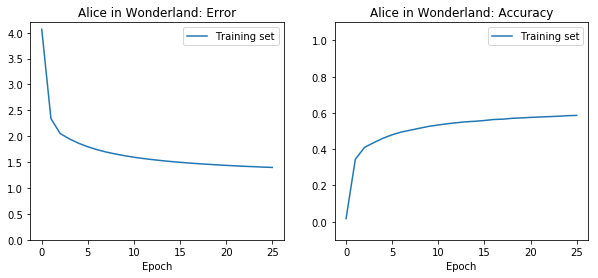

In [21]:
for iteration in range(25):
    print("=" * 50)
    print("Iteration #: %d" % (network.epoch_count))
    results = network.train(1, batch_size=128, plot=False, verbose=0)   
    sequence = network.dataset.inputs[cx.choice(len(network.dataset))]
    print("Generating from seed: '%s'" % ("".join([onehot_to_char(v) for v in sequence])))
    print("".join([onehot_to_char(v) for v in sequence]), end="")
    generate_text(sequence, 100)
network.plot_results()

What can you say about the text generated in later epochs compared to the earlier generated text?

This was the simplest and most straightforward of network architectures and parameter settings. Can you do better? Can you generate text that is better English, or even text that captures the style of Lewis Carroll?

Next, you might like to try this kind of experiment on your own sequential data. 